# Second level analysis: ANOVA + KMeans


1. run omnibus anova on all six beta maps to identify significant voxels
2. identify significant clusters from the omnibus anova
3. Extract average beta per cluster


*Yiyu Wang 2024 September*


In [ ]:
import os
import glob
import nibabel as nib
import numpy as np
import pandas as pd

from nilearn.image import new_img_like, concat_imgs, mean_img, math_img
from nilearn import plotting
from nilearn.glm.second_level import SecondLevelModel
from nilearn.reporting import get_clusters_table
from nilearn.glm import threshold_stats_img
from scipy.stats import norm
import scipy.stats as stats
from nilearn.maskers import NiftiLabelsMasker


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import math

import seaborn as sns
import matplotlib.pyplot as plt
from os.path import join


from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform


cluster_colors = ['#FFC800', '#7A3EB1', '#F76800'] 

def lighten_color(color, amount=0.5):
    import colorsys
    import matplotlib
    try:
        c = matplotlib.colors.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*matplotlib.colors.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])




In [ ]:
# local directory set up
gm_mask_img = nib.load('masks/gm_mask_icbm152_brain.nii.gz')

subjects_list = pd.read_csv('Data/included_SocialPred_subjects.csv', header=None)
subjects_list = subjects_list[0].values.tolist()
sample_n = len(subjects_list)
print("subjects in this analysis:")
print(subjects_list)
print(f"**** n = {sample_n} *****" )


TR = .001
N_TR = 675
TR_Length = 0.8
TR_IN_MS = int(TR_Length/TR)

fwhm = 0



subjects in this analysis:
[152, 179, 154, 158, 173, 153, 159, 174, 162, 145, 143, 181, 144, 169, 146, 167, 161, 182, 147, 166, 160, 185, 170, 176, 151, 157, 171, 177, 150, 156]
**** n = 30 *****


In [ ]:
# omnibus anova test in design matrix

model = 'model_final'

beta_dir = f'Results/{model}/1stLvl/'

second_level_res_dir = f'Results/{model}/omnibus_anova_F/'
if not os.path.isdir(second_level_res_dir):
    os.makedirs(second_level_res_dir)


vmax = 5
cluster_thre = 30
p_val = 0.05
p_unc = norm.isf(p_val)

p001 = 0.001
p001_unc = norm.isf(p001)

alpha = 0.05


# Regression model with an omnibus ANOVA design

In [ ]:
# design matrix for one sample test

file_list = []

obs_pattern, obs_social, fb_pattern_congruent, fb_social_congruent, fb_pattern_PE, fb_social_PE = [], [], [], [], [], []
for s in subjects_list:
    file_name = glob.glob(beta_dir + f'{s}/sub-{s}*z_score*obs_Pattern*.nii.gz')
    if len(file_name) != 0:
        file_list.append(file_name[0])
        obs_pattern.append(1)
        obs_social.append(0)
        fb_pattern_congruent.append(0)
        fb_social_congruent.append(0)
        fb_pattern_PE.append(0)
        fb_social_PE.append(0)
    else:
        print(f"no obs pattern for subject {s}")
for s in subjects_list:
    file_name = glob.glob(beta_dir + f'{s}/sub-{s}*z_score*obs_Social*.nii.gz')
    if len(file_name) != 0:
        file_list.append(file_name[0])
        obs_pattern.append(0)
        obs_social.append(1)
        fb_pattern_congruent.append(0)
        fb_social_congruent.append(0)
        fb_pattern_PE.append(0)
        fb_social_PE.append(0)
    else:
        print(f"no obs social for subject {s}")

for s in subjects_list:
    file_name = glob.glob(beta_dir + f'{s}/sub-{s}*z_score*fb_Social_Congruent*.nii.gz')
    if len(file_name) != 0:
        file_list.append(file_name[0])
        obs_pattern.append(0)
        obs_social.append(0)
        fb_pattern_congruent.append(0)
        fb_social_congruent.append(1)
        fb_pattern_PE.append(0)
        fb_social_PE.append(0)
    else:
        print(f"no fb social congruent for subject {s}")

for s in subjects_list:
    file_name = glob.glob(beta_dir + f'{s}/sub-{s}*z_score*fb_Social_PE*.nii.gz')
    if len(file_name) != 0:
        file_list.append(file_name[0])
        obs_pattern.append(0)
        obs_social.append(0)
        fb_pattern_congruent.append(0)
        fb_social_congruent.append(0)
        fb_pattern_PE.append(0)
        fb_social_PE.append(1)
    else:
        print(f"no fb social PE for subject {s}")

for s in subjects_list:
    file_name = glob.glob(beta_dir + f'{s}/sub-{s}*z_score*fb_Pattern_Congruent*.nii.gz')
    if len(file_name) != 0:
        file_list.append(file_name[0])
        obs_pattern.append(0)
        obs_social.append(0)
        fb_pattern_congruent.append(1)
        fb_social_congruent.append(0)
        fb_pattern_PE.append(0)
        fb_social_PE.append(0)
    else:
        print(f"no fb pattern congruent for subject {s}")
for s in subjects_list:
    file_name = glob.glob(beta_dir + f'{s}/sub-{s}*z_score*fb_Pattern_PE*.nii.gz')
    if len(file_name) != 0:
        file_list.append(file_name[0])
        obs_pattern.append(0)
        obs_social.append(0)
        fb_pattern_congruent.append(0)
        fb_social_congruent.append(0)
        fb_pattern_PE.append(1)
        fb_social_PE.append(0)
    else:
        print(f"no fb pattern PE for subject {s}")
        
second_level_input = file_list

design_columns = ['obs_Pattern', 'obs_Social', 'fb_Pattern_Congruent', 'fb_Social_Congruent', 'fb_Pattern_PE', 'fb_Social_PE']

X = pd.concat([pd.Series(obs_pattern), 
               pd.Series(obs_social),
               pd.Series(fb_pattern_congruent),
               pd.Series(fb_social_congruent),
               pd.Series(fb_pattern_PE),
               pd.Series(fb_social_PE)], axis=1)
X.columns= design_columns

second_level_input = file_list
print(file_list)
print(len(file_list))


second_level_model = SecondLevelModel()
second_level_model = second_level_model.fit(second_level_input,
                                            design_matrix=X)

plotting.plot_design_matrix(X, output_file=join(second_level_res_dir, f'design_matrix.png'))

# test to make sure no difference between how the contrast is defined
# omnibus_contrast = np.array([[1, -1, 0, 0, 0, 0],   
#                               [1, 0, -1, 0, 0, 0],   
#                               [1, 0, 0, -1, 0, 0],   
#                               [1, 0, 0, 0, -1, 0],
#                               [1, 0, 0, 0, 0, -1]])  
omnibus_contrast = np.array([[0, -1, 0, 0, 0, 1],   
                              [0, 0, -1, 0, 0, 1],   
                              [0, 0, 0, -1, 0, 1],   
                              [0, 0, 0, 0, -1, 1],
                              [-1, 0, 0, 0, 0, 1]])  
# check rank of the contrast matrix for singular matrix
rank_omnibus_contrast = np.linalg.matrix_rank(omnibus_contrast)
print(f"Rank of the omnibus contrast matrix: {rank_omnibus_contrast}")

group_res = second_level_model.compute_contrast(omnibus_contrast,output_type='all', second_level_stat_type='F')
for stats_name in group_res.keys():
    res = group_res[stats_name]
    nii_file_path = second_level_res_dir + f'omnibus_anova_{stats_name}.nii.gz'
    print(f"saving {nii_file_path}")
    nib.save(res, nii_file_path)

In [9]:

# Function to find the optimal k
def find_best_k(data, max_k=10):
    inertia = []
    silhouette_scores = []
    K = range(2, max_k + 1)  # Start from 2 clusters since silhouette doesn't support 1

    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        
        # Inertia for the elbow method
        inertia.append(kmeans.inertia_)
        
        # Silhouette score
        silhouette_avg = silhouette_score(data, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)

    # Finding the elbow point (best k for inertia method)
    # Use a heuristic to find the elbow by calculating the second derivative.
    inertia_diff = np.diff(inertia)  # First derivative
    inertia_diff2 = np.diff(inertia_diff)  # Second derivative
    elbow_k = np.argmax(inertia_diff2) + 3  # Adding 3 because we took two derivatives

    # Finding the best k based on silhouette score
    best_silhouette_k = np.argmax(silhouette_scores) + 2  # +2 because K starts at 2

    # Plotting the Elbow method
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(K, inertia, 'bo-', label='Inertia')
    plt.axvline(x=elbow_k, color='g', linestyle='--', label=f'Elbow at k={elbow_k}')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.grid(True)
    plt.legend()

    # Plotting the Silhouette scores
    plt.subplot(1, 2, 2)
    plt.plot(K, silhouette_scores, 'ro-', label='Silhouette Score')
    plt.axvline(x=best_silhouette_k, color='g', linestyle='--', label=f'Best k={best_silhouette_k}')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score for Optimal k')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"Best k by Elbow method: {elbow_k}")
    print(f"Best k by Silhouette method: {best_silhouette_k}")

    # Return the best k for both methods
    return {'best_k_elbow': elbow_k, 'best_k_silhouette': best_silhouette_k}


def CreateClusterMeanBeta(masker):
    ClusterMeanBeta = []
    ClusterStdBeta = []
    
    column_names = ['obs_Pattern', 'obs_Social', 'fb_Pattern_Congruent', 'fb_Social_Congruent', 'fb_Pattern_PE', 'fb_Social_PE']
    for column in column_names:
        file_list = glob.glob(beta_dir + f'*/sub-*z_score*{column}*.nii.gz')
        img = concat_imgs(file_list)
        beta_avg = mean_img(img)
        beta_mean = masker.fit_transform(beta_avg)
        print(beta_mean.shape)
        ClusterMeanBeta.append(beta_mean.T)
        
        beta_std = np.std(img.get_fdata(), axis=-1)
        sample_size = img.shape[-1]
        standard_error = beta_std / np.sqrt(sample_size)
        
        beta_sem = new_img_like(beta_avg, standard_error)
        beta_sem = masker.fit_transform(beta_sem)
        ClusterStdBeta.append(beta_sem.T)
    
    ClusterMeanBeta = np.array(ClusterMeanBeta)
    ClusterMeanBeta = ClusterMeanBeta.squeeze()
    print(ClusterMeanBeta.shape)
    df  = pd.DataFrame(ClusterMeanBeta.T, columns=column_names)
    

    ClusterStdBeta = np.array(ClusterStdBeta)
    ClusterStdBeta = ClusterStdBeta.squeeze()
    print(ClusterStdBeta.shape)
    df_std  = pd.DataFrame(ClusterStdBeta.T, columns=column_names)
    plot_names = ['Cue-AI', 'Cue-AD', 'Feedback Congruent AI', 'Feedback Congruent AD', 'Feedback Pred Error AI', 'Feedback Pred Error AD']
    df.columns = plot_names
    df_std.columns = plot_names
    
    return df, df_std

def CreateBarPlotsForClusters(df, df_err = None, title = '', subtitle_list=[],  color_list=None):
    # Number of clusters
    num_clusters = len(df)

    # Get the global minimum and maximum values across all clusters for uniform y-axis scaling
    y_min = df.min().min() - 0.1
    y_max = df.max().max() + 0.1

    # Create subplots
    if num_clusters < 10:
        n_rows=1
        n_cols = num_clusters
        fig_size = (15, 5)
    else:
        n_rows=5
        n_cols = math.ceil(num_clusters / n_rows)
        fig_size = (15, 10)

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=fig_size)
    axes = axes.flatten()

    # Iterate through each cluster and create a bar plot
    if color_list is None:
        # make a color list of grays for each cluster
        color_list = ['gray'] * num_clusters


    for i in range(num_clusters):
        if df_err is not None:
            df.iloc[i].plot(kind='bar', ax=axes[i], yerr=df_err.iloc[i], color=color_list[i], width=0.6)
        else:   
            df.iloc[i].plot(kind='bar', ax=axes[i], color=color_list[i], width=0.6)
        
        axes[i].set_title(f'{subtitle_list[i]}' if subtitle_list else f'Brain Region {i+1}')
        # Only set x-axis label for the bottom-most subplots
        if i >= num_clusters - n_cols:  # Last row of subplots
            axes[i].set_xlabel(' ')
            axes[i].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)  # Show x-ticks
        else:
            axes[i].set_xlabel('')  # Remove x-axis label
            axes[i].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # Remove x-ticks


        # Only set y-axis label once if there are multiple rows
        if i % n_cols == 0:  # First column of subplots
            axes[i].set_ylabel('Mean Parameter Estimate (z)')
        else:
            axes[i].set_ylabel('')  # Remove y-axis label

        # Set uniform y-axis limits
        axes[i].set_ylim([y_min, y_max])
    
        # Remove gridlines
        axes[i].grid(False)

    # If there are any unused subplots, hide them
    for j in range(num_clusters, n_rows * n_cols):
        fig.delaxes(axes[j])
    # Set a global title
    fig.suptitle(title, fontsize=14)
    # Display the plots
    plt.show()
    plt.clf()
    plt.close()



In [ ]:


group_res_zscore = nib.load(f'{second_level_res_dir}omnibus_anova_z_score.nii.gz')
gm_mask_img = nib.load('masks/gm_mask_icbm152_brain.nii.gz')
group_res_zscore = math_img('img1 * img2', img1=group_res_zscore, img2=gm_mask_img)

thresholded_map, second_level_threshold = threshold_stats_img(group_res_zscore, 
                                    alpha=0.05,
                                    height_control='fdr')


print(f"second level threshold: fdr ={second_level_threshold}")

plotting.plot_stat_map(thresholded_map)
# save the thresholded map
nib.save(thresholded_map, f'{second_level_res_dir}omnibus_anova_z_score_fdr.nii.gz')
table, label_maps = get_clusters_table(group_res_zscore, stat_threshold=second_level_threshold, cluster_threshold=50, return_label_maps=True)

# create labels masker
masker = NiftiLabelsMasker(label_maps[0], standardize=False)


# run kmeans to further reduce the number of clusters
# run kmeans at the subject level: n ROIs x 6 features x 30 subjects => n x 180 matrix
from nilearn.image import load_img
all_sub_z = load_img(second_level_input) # 91, 109, 91, 180
print(all_sub_z.shape)
roi_sub_z = masker.fit_transform(all_sub_z) # 180 x n clusters

roi_sub_z_df = pd.DataFrame(roi_sub_z)

video_name_list = [f.split("video-")[1].split("_gm_masked.nii")[0] for f in second_level_input]
s_name_list = [f.split("sub-")[1].split("_z")[0] for f in second_level_input]
roi_sub_z_df['sub_video'] = [f"sub-{s}_video-{v}" for s, v in zip(s_name_list, video_name_list)]
roi_sub_z_df['video'] = video_name_list
df_grouped = roi_sub_z_df.groupby('video').mean().T
df_grouped = df_grouped.reset_index(drop=True)





# Figure S6

Optimal number of clusters: 3


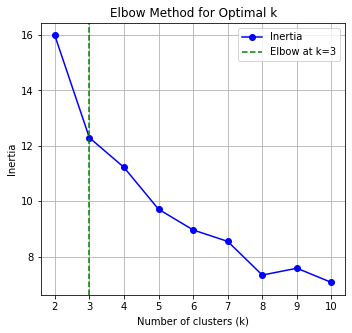

In [ ]:
from sklearn.preprocessing import normalize
from sklearn.cluster import MiniBatchKMeans
from kneed import KneeLocator
from sklearn.metrics import silhouette_samples, silhouette_score

X = roi_sub_z_df.iloc[:, 0:-2].T
X_normalized = normalize(X)  # ensures unit-length rows

inertias = []
K = range(2, 11)


for k in K:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_normalized)
    inertias.append(kmeans.inertia_)
    

# Find the "elbow" point by taking two derivatives
inertia_diff = np.diff(inertias)  # First derivative
inertia_diff2 = np.diff(inertia_diff)  # Second derivative
elbow_k = np.argmax(inertia_diff2) + 3  # Adding 3 because we took two derivatives

# Plotting the Elbow method
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K, inertias, 'bo-', label='Inertia')
plt.axvline(x=elbow_k, color='g', linestyle='--', label=f'Elbow at k={elbow_k}')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.legend()

# Print the optimal number of clusters
print(f"Optimal number of clusters: {elbow_k}")


In [ ]:
X = roi_sub_z_df.iloc[:, 0:-2].T

from sklearn_extra.cluster import KMedoids

# make consine distance
X_normalized = normalize(X)  # now cosine distance ~ euclidean on unit sphere

model = MiniBatchKMeans(n_clusters=3, random_state=42)
cluster_labels = model.fit_predict(X_normalized)


cluster_labels = cluster_labels + 1
print(cluster_labels)


# for visualization, change cluster label 1 to 3, 2 to 1, and 3 to 2
cluster_labels = np.where(cluster_labels == 1, 4, cluster_labels)
cluster_labels = np.where(cluster_labels == 2, 1, cluster_labels)
cluster_labels = np.where(cluster_labels == 3, 2, cluster_labels)
cluster_labels = np.where(cluster_labels == 4, 3, cluster_labels)
print(cluster_labels)

In [ ]:
# # drop column 11 (which is roi #12) for roi_sub_z_df because it is not a valid gray matter roi upon visual inspection
roi_sub_z_df.drop(columns=[11], inplace=True)
# remove row 11 for df_grouped
df_grouped.drop(index=11, inplace=True)


# change the masker
# after review, removing brain region 12 that is not a valid cluster
label_map = label_maps[0]
label_map_data = label_map.get_fdata()
label_map_data[label_map_data == 12] = 0  # set the label to 0


# shift the later brain region numbers up
for i in range(13, 32 + 1):
    label_map_data[label_map_data == i] = i - 1  # shift the label up by 1


# save the updated label map
new_label_map = new_img_like(label_map, label_map_data)

# create new masker
masker = NiftiLabelsMasker(new_label_map, standardize=False).fit()

cluster_labels_img = masker.inverse_transform(cluster_labels)
# save the cluster labels image


In [ ]:
df_grouped_transposed = roi_sub_z_df.T
df_grouped_transposed.columns = df_grouped_transposed.iloc[-2]
df_grouped_transposed.drop(df_grouped_transposed.tail(2).index, inplace = True)
df_grouped_transposed['Cluster'] = df_grouped['Cluster']

df_grouped_transposed.groupby('Cluster').count()

In [ ]:
data = roi_sub_z_df.copy()
cluster_dict = pd.DataFrame({'brain_region': [f'brain_region_{i}' for i in range(1, len(df_grouped_transposed)+1)], 'cluster': df_grouped['Cluster']})
# drop the video_column
data = data.drop(columns=['sub_video'])

data.columns = [f'brain_region_{i}' for i in range(1, len(df_grouped_transposed)+1)] + ['trial']



data['condition'] = data['trial'].str.split('_', expand=True)[1]
# rename condition to Social = agent-dependent, Pattern = agent-independent
data.loc[data['condition']=='Social', 'condition'] = 'agent-dependent'
data.loc[data['condition']=='Pattern', 'condition'] = 'agent-independent'
data['video'] = data['trial'].str.split('_', expand=True)[0]
data['PE'] = data['trial'].str.split('_', expand=True)[2]
data.loc[data['video']=='obs', 'PE'] = 'obs'
# drop video column and name PE column as video
data = data.drop(columns=['video'])
data = data.rename(columns={'PE':'video'})


In [ ]:
# manual labeling of clusters outside this script before running the rest of the code
roi_name_df = pd.read_csv(f'{second_level_res_dir}cluster_table_annotated.csv')
roi_name_df

In [ ]:
roi_name_df.rename(columns={'Cluster ID':'brain_region'}, inplace=True)
roi_name_df['brain_region'] = roi_name_df['brain_region'].apply(lambda x: f"brain_region_{x}")


roi_name_df

# Figure S5

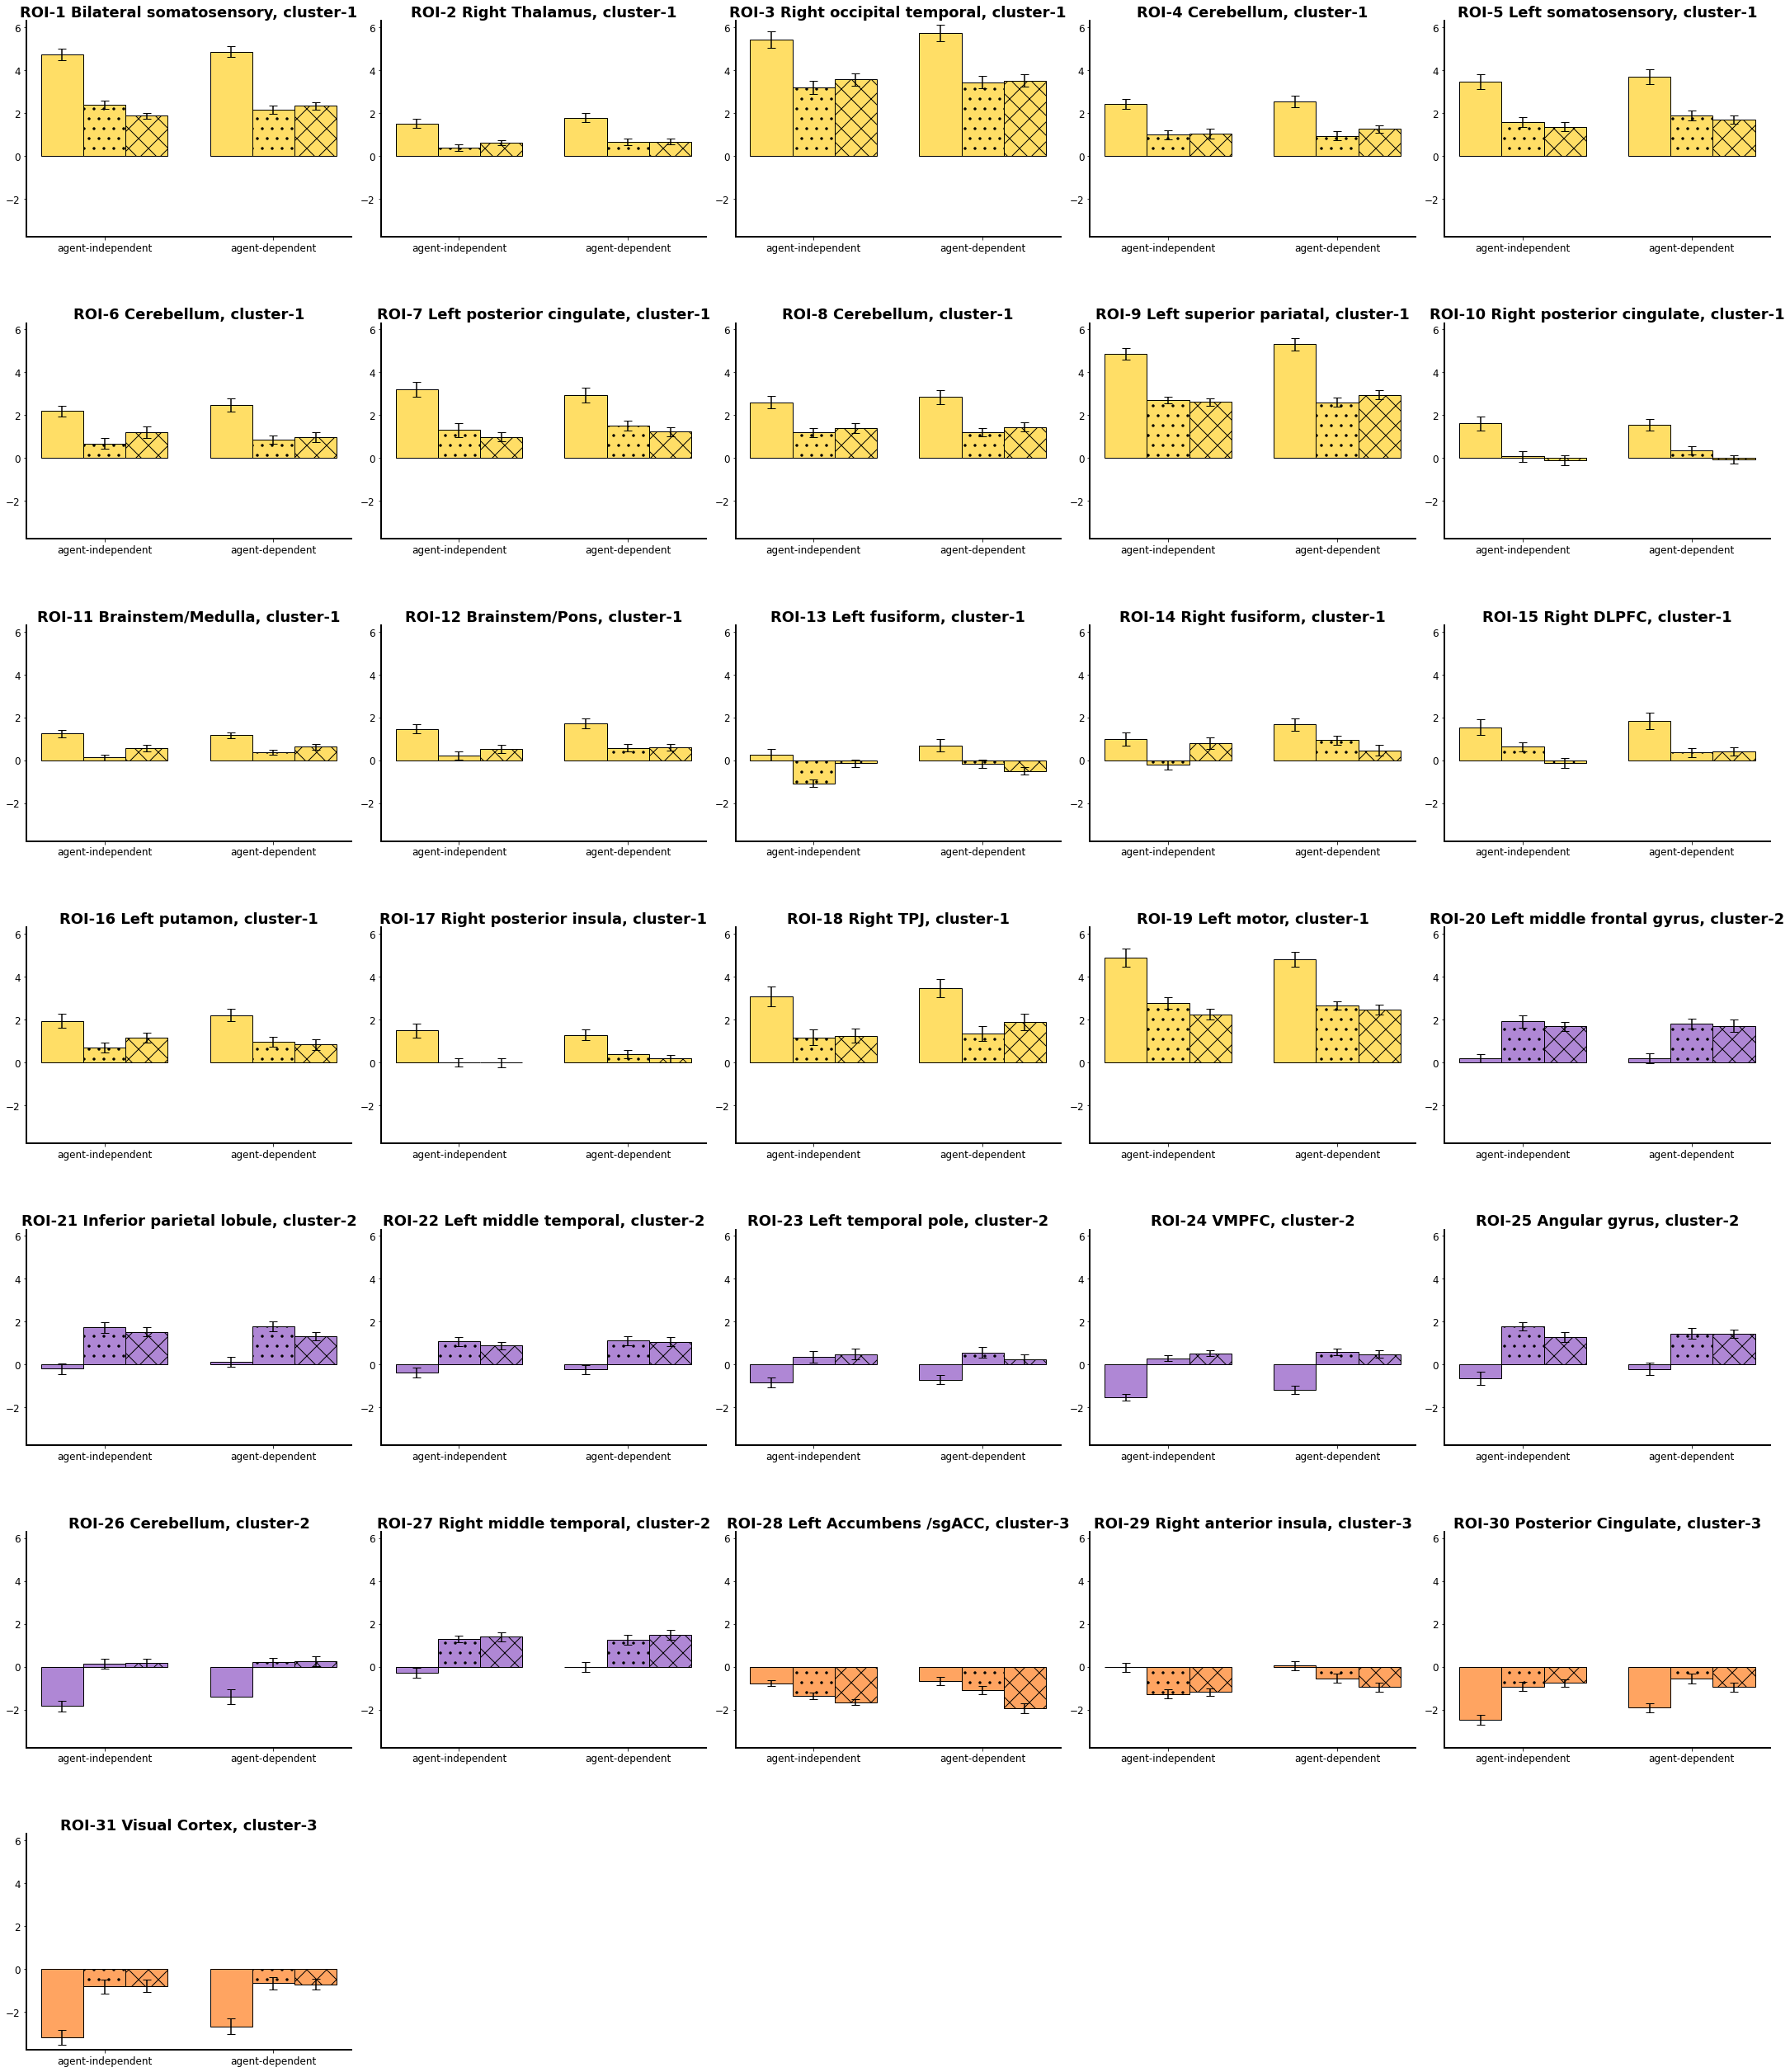

In [ ]:

region_to_name = roi_name_df.set_index("brain_region")["roi_name"].to_dict()

metadata_cols = ['condition', 'video', 'trial']
brain_regions = [col for col in data.columns if col not in metadata_cols]

n_regions = len(brain_regions)
n_cols = min(n_regions, 5)
n_rows = int(np.ceil(n_regions / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
axes = axes.ravel()


# map brain region to cluster
region_to_cluster = cluster_dict.set_index("brain_region")["cluster"].to_dict()

# Sort brain regions based on cluster number (regions without a cluster go to the end)
brain_regions = sorted(
    [col for col in data.columns if col not in metadata_cols],
    key=lambda region: (region_to_cluster.get(region, float('inf')), region)
)


feedback_types = ['obs', 'Congruent', 'PE']
width = 0.25

# Compute global y-limits
all_values, all_sems = [], []
for region in brain_regions:
    for fb in feedback_types:
        for cond in data['condition'].unique():
            subset = data[(data['condition'] == cond) & (data['video'] == fb)]
            all_values.append(subset[region].mean())
            all_sems.append(subset[region].sem())
max_value = max(all_values) + max(all_sems) + 0.1
min_value = min(all_values) - max(all_sems) - 0.1

for idx, region in enumerate(brain_regions):
    ax = axes[idx]

    region_name = region_to_name.get(region, 'Unknown')
    cluster = region_to_cluster.get(region, 'Unknown')

    base_color = cluster_colors_dict.get(str(cluster), '#999999')
    light_color = lighten_color(base_color, 0.6)
    

    conditions = data['condition'].unique()
    x = np.arange(len(conditions))

    for i, fb_type in enumerate(feedback_types):
        means, sems = [], []
        for cond in conditions:
            subset = data[(data['condition'] == cond) & (data['video'] == fb_type)]
            means.append(subset[region].mean())
            sems.append(subset[region].sem())

        if fb_type == 'obs':
            color = light_color
            hatch = ''
        elif fb_type == 'PE':
            color = light_color
            hatch = 'x'
        else:
            color = light_color
            hatch = '.'

        ax.bar(x + (i-1)*width, means, width, 
                label=fb_type, color=color, hatch=hatch,
                yerr=sems, capsize=5, edgecolor='black', linewidth=1)
        


    ax.set_title(f'ROI-{idx+1} {region_name}, cluster-{cluster}', fontsize=18, pad=5, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(conditions, fontsize=14)
    ax.tick_params(axis='both', labelsize=12)
    ax.set_ylim([min_value, max_value])
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Hide unused subplots
for j in range(len(brain_regions), len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
fig.subplots_adjust(hspace=0.4)

In [27]:
roi_sub_z_df_cluster = df_grouped_transposed.groupby('Cluster').mean()
roi_sub_z_df_cluster

sub_video,sub-152_video-obs_Pattern,sub-179_video-obs_Pattern,sub-154_video-obs_Pattern,sub-158_video-obs_Pattern,sub-173_video-obs_Pattern,sub-153_video-obs_Pattern,sub-159_video-obs_Pattern,sub-174_video-obs_Pattern,sub-162_video-obs_Pattern,sub-145_video-obs_Pattern,...,sub-166_video-fb_Pattern_PE,sub-160_video-fb_Pattern_PE,sub-185_video-fb_Pattern_PE,sub-170_video-fb_Pattern_PE,sub-176_video-fb_Pattern_PE,sub-157_video-fb_Pattern_PE,sub-171_video-fb_Pattern_PE,sub-177_video-fb_Pattern_PE,sub-150_video-fb_Pattern_PE,sub-156_video-fb_Pattern_PE
Cluster,,,,,,,,,,,,,,,,,,,,,
1,3.137962,3.323199,2.694692,3.056285,4.225833,1.664957,3.589005,2.805051,1.779883,2.224389,...,2.222336,0.648991,2.004360,1.871451,0.314179,0.591028,-0.013297,0.454685,0.780990,1.821532
2,-0.737824,1.074863,-0.951116,-0.598244,-2.379377,-1.123800,1.023971,-0.127589,-1.822037,-2.099062,...,2.114700,0.847697,1.744776,2.284974,1.700628,0.931998,-0.069481,0.567206,0.942470,0.933374
3,-0.759854,-1.187232,-2.228248,-1.602736,-2.326859,-1.573730,-0.485488,-1.124035,-2.274574,-2.234179,...,-0.863761,-1.922830,-2.178831,-0.636646,-0.792525,-1.154728,-1.795959,-0.917937,-0.883318,-1.068266


## run cluster level statistics between the six conditions

In [ ]:

import pingouin as pg

cue_cols = [col for col in df_grouped_transposed.columns if 'obs_' in col]
fb_cols = [col for col in df_grouped_transposed.columns if 'fb_' in col]
roi_sub_z_df_cue = roi_sub_z_df_cluster[cue_cols]
roi_sub_z_df_fb = roi_sub_z_df_cluster[fb_cols]

# average social pattern cue videos such that the df is 3x30
sub_id_list = [col.split('sub-')[1].split("_video")[0] for col in roi_sub_z_df_cue.columns]
sub_id_list = ['sub-' + str(sub_id) for sub_id in sub_id_list]
roi_sub_z_df_cue = roi_sub_z_df_cue.T.reset_index(drop=True)
roi_sub_z_df_cue['sub'] = sub_id_list
roi_sub_z_df_cue = roi_sub_z_df_cue.groupby('sub').mean().T

# average Congruent and PE fb videos such that the df is 3x30
sub_id_list = [col.split('sub-')[1].split("_video")[0] for col in roi_sub_z_df_fb.columns]
sub_id_list = ['sub-' + str(sub_id) for sub_id in sub_id_list]
roi_sub_z_df_fb = roi_sub_z_df_fb.T.reset_index(drop=True)
roi_sub_z_df_fb['sub'] = sub_id_list
roi_sub_z_df_fb = roi_sub_z_df_fb.groupby('sub').mean().T


for cluster in roi_sub_z_df_cluster.index:
    cue_values = roi_sub_z_df_cue.loc[cluster].values
    fb_values = roi_sub_z_df_fb.loc[cluster].values
    
    # Perform the t-test
    t_test_result = pg.ttest(cue_values, fb_values, paired=True)
    pg.print_table(t_test_result)

In [ ]:
# select cue video columns
cue_pattern_cols = [col for col in df_grouped_transposed.columns if 'obs_Pattern' in col]
cue_social_cols = [col for col in df_grouped_transposed.columns if 'obs_Social' in col]
cue_pattern_df = roi_sub_z_df_cluster[cue_pattern_cols]
cue_social_df = roi_sub_z_df_cluster[cue_social_cols]
cue_social_df

In [ ]:
# for each cluster, test whether there is a significant difference between the pattern and social conditions


for cluster in roi_sub_z_df_cluster.index:
    pattern_values = cue_pattern_df.loc[cluster].values
    social_values = cue_social_df.loc[cluster].values
    
    # Perform the t-test
    t_test_result = pg.ttest(pattern_values, social_values, paired=True)
    
    pg.print_table(t_test_result) 

In [ ]:
fd_cols = [col for col in df_grouped_transposed.columns if 'fb_' in col]
fb_df = roi_sub_z_df_cluster[fd_cols]

df_groupd = fb_df.groupby('Cluster').mean()
sub_id_list = [col.split('sub-')[1].split("_video")[0] for col in df_groupd.columns]
sub_id_list = ['sub-' + str(sub_id) for sub_id in sub_id_list]
df_groupd.columns = [col.split('video-')[1] for col in df_groupd.columns]
df_groupd = df_groupd.T.reset_index()
df_groupd.columns = ['trial'] + [f'Cluster-{i}' for i in roi_sub_z_df_cluster.index]
df_groupd['condition'] = df_groupd['trial'].str.split('_', expand=True)[1]
# rename condition to Social = agent-dependent, Pattern = agent-independent/
df_groupd.loc[df_groupd['condition']=='Social', 'condition'] = 'agent-dependent'
df_groupd.loc[df_groupd['condition']=='Pattern', 'condition'] = 'agent-independent'
df_groupd['feedback_type'] = df_groupd['trial'].str.split('_', expand=True)[0]
df_groupd['PE'] = df_groupd['trial'].str.split('_', expand=True)[2]
df_groupd.loc[df_groupd['feedback_type']=='obs', 'PE'] = 'obs'
# drop video column and name PE column as video
df_groupd = df_groupd.drop(columns=['feedback_type'])
df_groupd = df_groupd.rename(columns={'PE':'feedback_type'})
df_groupd['subject']=sub_id_list
df_groupd

In [ ]:

for i in roi_sub_z_df_cluster.index:
    aov = pg.rm_anova(dv=f'Cluster-{i}', within=['condition', 'feedback_type'],
                    subject='subject', data=df_groupd)
    pg.print_table(aov)
 

# Figure 2a

In [ ]:
# make surface objects

overlay = cluster_labels_img
for i in range(1, 4):
    nib.save(math_img(f'img1 == {i}', img1=overlay), f'{second_level_res_dir}cluster_{i}.nii.gz')


In [ ]:
from nilearn.datasets import fetch_surf_fsaverage
from nilearn import surface

fsaverage = fetch_surf_fsaverage()

overlay = cluster_labels_img
# make bar plots for each cluster

for cluster in df_grouped_transposed['Cluster'].unique():
    cluster_df = df_grouped_transposed[df_grouped_transposed['Cluster']==cluster]
    
    for video in ['obs_Pattern', 'obs_Social', 'fb_Pattern_PE', 'fb_Social_PE', 'fb_Pattern_Congruent', 'fb_Social_Congruent']:
        video_df = cluster_df[cluster_df.columns[cluster_df.columns.str.contains(video)]]
        

# since suface rendering is a probablistic interpolation, set a threshold for binarizing:
texture_threshold = 0.5

# Binarize the img for groups 1 to 3
groups = [math_img(f'img1 == {i}', img1=overlay) for i in range(1, 4)]

surfaces = [fsaverage.pial_right, fsaverage.pial_left]

# Process each group
textures = {}
for i, group in enumerate(groups, start=1):
    textures[f'right{i}'], textures[f'left{i}'] = [
        np.where(surface.vol_to_surf(group, surf, interpolation='nearest') > texture_threshold, i, 0)
        for surf in surfaces
    ]

sum_texture_right = sum(textures[f'right{i}'] for i in range(1, 4))
sum_texture_left = sum(textures[f'left{i}'] for i in range(1, 4))    


group 1
group 2
group 3


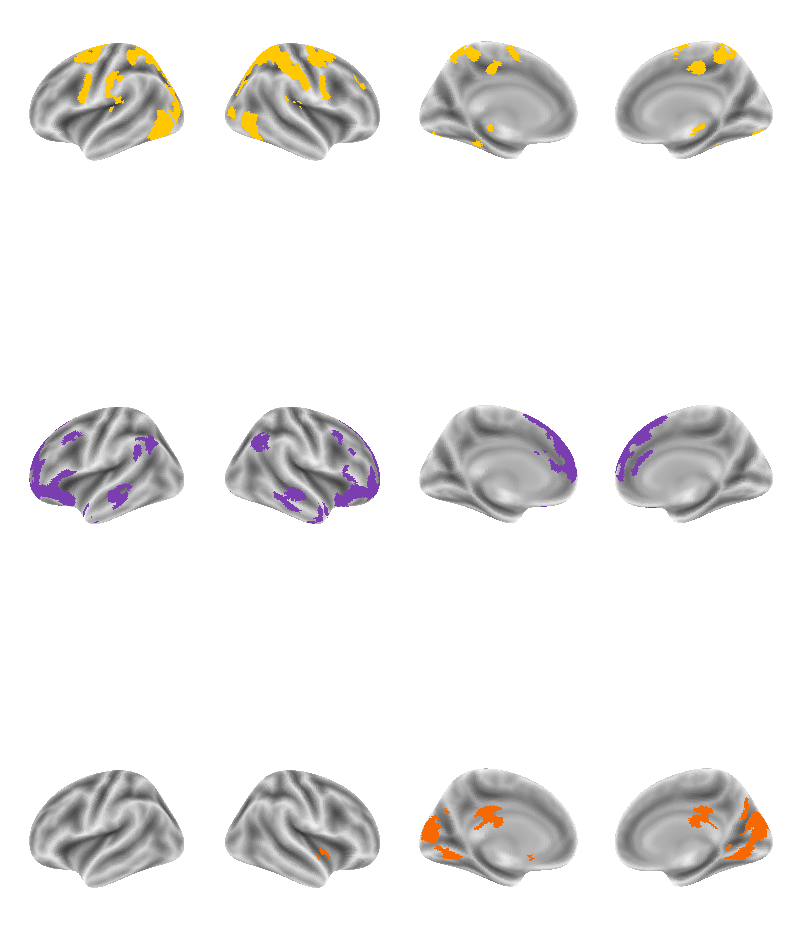

In [ ]:

# since suface rendering is a probablistic interpolation, set a threshold for binarizing:
texture_threshold = 0.5


# Binarize the img for groups 1 to 4
groups = [math_img(f'img1 == {i}', img1=overlay) for i in range(1, 4)]

surfaces = [fsaverage.pial_right, fsaverage.pial_left]

# Process each group
textures = {}
for i, group in enumerate(groups, start=1):
    print(f'group {i}')
    textures[f'right{i}'], textures[f'left{i}'] = [
        np.where(surface.vol_to_surf(group, surf, interpolation='nearest') > texture_threshold, 1, 0)
        for surf in surfaces
    ]

vmin = 0

vmax = 3
my_cmap = matplotlib.colors.ListedColormap(cluster_colors)

# Create a 4x4 subplot layout for each group
fig, axes = plt.subplots(nrows=vmax, ncols=4, figsize=(14, 20), subplot_kw={'projection': '3d'})

# make axes tighter
plt.subplots_adjust(wspace=0.01, hspace=0.01)
# Iterate over each group and plot left & right hemispheres
for i in range(1, vmax+1):
    plotting.plot_surf(
        fsaverage.infl_left, textures[f'left{i}'], view='lateral', hemi='left',
        colorbar=False, cmap=matplotlib.colors.ListedColormap(['#FFFFFF', cluster_colors[i-1]]), threshold=threshold, vmin=0, vmax=1,
        avg_method='median', cbar_vmin=0, cbar_vmax=3,
        bg_map=fsaverage.sulc_left, axes=axes[i-1, 0], darkness=0.8, inflate=True
    )

    plotting.plot_surf(
        fsaverage.infl_right, textures[f'right{i}'], view='lateral', hemi='right',
        colorbar=False, cmap=matplotlib.colors.ListedColormap(['#FFFFFF', cluster_colors[i-1]]), threshold=threshold, vmin=0, vmax=1,
        avg_method='median', cbar_vmin=0, cbar_vmax=3,
        bg_map=fsaverage.sulc_right, axes=axes[i-1, 1], darkness=0.8, inflate=True
    )
    
    plotting.plot_surf(
        fsaverage.infl_left, textures[f'left{i}'], view='medial', hemi='left',
        colorbar=False, cmap=matplotlib.colors.ListedColormap(['#FFFFFF', cluster_colors[i-1]]), threshold=threshold, vmin=0, vmax=1,
        avg_method='median', cbar_vmin=0, cbar_vmax=3,
        bg_map=fsaverage.sulc_left, axes=axes[i-1, 2], darkness=0.8, inflate=True
    )

    plotting.plot_surf(
        fsaverage.infl_right, textures[f'right{i}'], view='medial', hemi='right',
        colorbar=False, cmap=matplotlib.colors.ListedColormap(['#FFFFFF', cluster_colors[i-1]]), threshold=threshold, vmin=0, vmax=1,
        avg_method='median', cbar_vmin=0, cbar_vmax=3,
        bg_map=fsaverage.sulc_right, axes=axes[i-1, 3], darkness=0.8, inflate=True
    )



plt.show()


<AxesSubplot:>

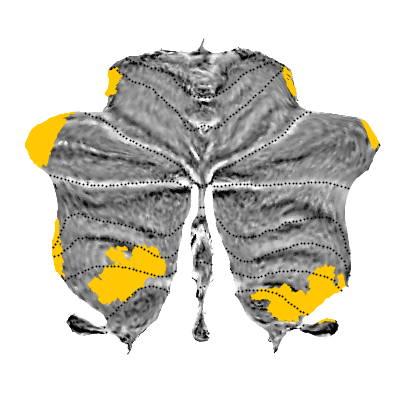

In [37]:
# make cerebellum plot for cluster group 1
import SUITPy.flatmap as flatmap
import matplotlib.colors as mcolors
import matplotlib.cm as cm
overlay_group1 = math_img('img == 1', img=overlay)
# make cmap based on the cluster colors
# Define the color
hex_color = cluster_colors[0]
# Convert to RGB
rgb_color = mcolors.hex2color(hex_color)
# Create a colormap from a single color
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", [(0, rgb_color), (1, rgb_color)])

funcdata = flatmap.vol_to_surf(overlay_group1,space='MNISymC')
# binarize funcdata if > 0.2
funcdata[funcdata>=0.2] = 1
funcdata[funcdata<0.2] = 0
# Make gifti image with the right column names
flatmap.plot(data=funcdata, cmap=cmap, \
    threshold=0.02, \
    new_figure=True, \
    colorbar=False, \
    render='matplotlib')


<AxesSubplot:>

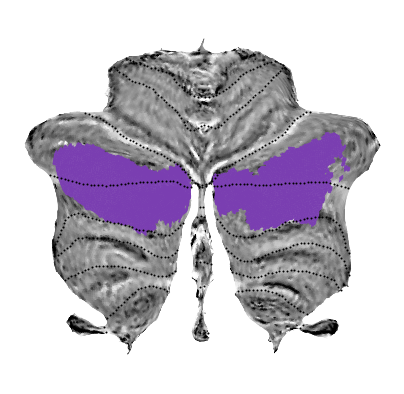

In [38]:
# make cerebellum plot for cluster group 2
import SUITPy.flatmap as flatmap
import matplotlib.colors as mcolors
import matplotlib.cm as cm
overlay_group2 = math_img('img == 2', img=overlay)
# make cmap based on the cluster colors
hex_color = cluster_colors[1]
rgb_color = mcolors.hex2color(hex_color)
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", [(0, rgb_color), (1, rgb_color)])

funcdata = flatmap.vol_to_surf(overlay_group2,space='MNISymC')
# binarize funcdata if > 0.2
funcdata[funcdata>=0.2] = 1
funcdata[funcdata<0.2] = 0
# Make gifti image with the right column names
flatmap.plot(data=funcdata, cmap=cmap, \
    threshold=0.02, \
    new_figure=True, \
    colorbar=False, \
    render='matplotlib')


<AxesSubplot:>

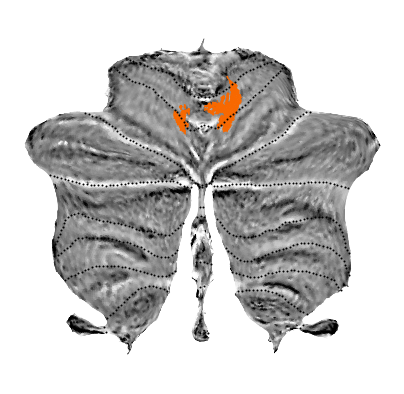

In [39]:
# make cerebellum plot for cluster group 3
import SUITPy.flatmap as flatmap
import matplotlib.colors as mcolors
import matplotlib.cm as cm
overlay_group3 = math_img('img == 3', img=overlay)
# make cmap based on the cluster colors
hex_color = cluster_colors[2]
rgb_color = mcolors.hex2color(hex_color)
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", [(0, rgb_color), (1, rgb_color)])

funcdata = flatmap.vol_to_surf(overlay_group3,space='MNISymC')
# binarize funcdata if > 0.2
funcdata[funcdata>=0.2] = 1
funcdata[funcdata<0.2] = 0
# Make gifti image with the right column names
flatmap.plot(data=funcdata, cmap=cmap, \
    threshold=0.02, \
    new_figure=True, \
    colorbar=False, \
    render='matplotlib')


# Figure S3

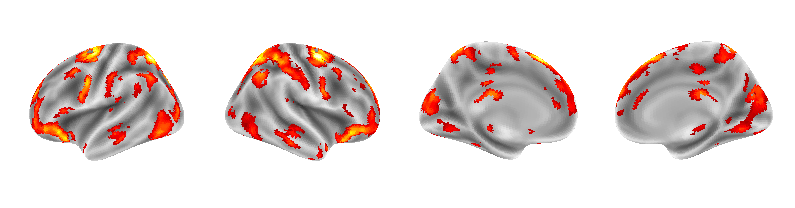

In [ ]:


texture_threshold = 0.5

# Binarize the img for groups 1 to 4
overlay_mask = math_img(f'img1 !=0', img1=overlay)

surfaces = [fsaverage.pial_right, fsaverage.pial_left]

# Process each group
textures_mask = {}

textures_mask['right'], textures_mask['left'] = [
        np.where(surface.vol_to_surf(overlay_mask, surf, interpolation='nearest') > texture_threshold, 1, 0)
        for surf in surfaces]



cmap='hot'

# Iterate over each group and plot left & right hemispheres
z_surface = {}
for hemi in ["left", "right"]:
    surface_image = surface.vol_to_surf(
    thresholded_map,
    surf_mesh=fsaverage[f"pial_{hemi}"],
    inner_mesh=fsaverage[f"white_{hemi}"],
    interpolation='nearest')

    # mask the surface image by the textures, which is binary for each cluster
    surface_image_masked = np.where(textures_mask[f'{hemi}'] ==1, surface_image, 0)
    z_surface[hemi] = surface_image_masked

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(14, 20), subplot_kw={'projection': '3d'})
# make axes tighter
plt.subplots_adjust(wspace=0.01, hspace=0.01)
# Iterate over each group and plot left & right hemispheres

plotting.plot_surf(
    fsaverage.infl_left, z_surface['left'], view='lateral', hemi='left',
    colorbar=False, cmap=cmap, threshold=second_level_threshold, 
    avg_method='median', 
    bg_map=fsaverage.sulc_left, axes=axes[0], darkness=0.8, inflate=True
)

plotting.plot_surf(
    fsaverage.infl_right, z_surface['right'], view='lateral', hemi='right',
    colorbar=False, cmap=cmap, threshold=second_level_threshold, 
    avg_method='median', 
    bg_map=fsaverage.sulc_right, axes=axes[1], darkness=0.8, inflate=True
)

plotting.plot_surf(
    fsaverage.infl_left, z_surface['left'], view='medial', hemi='left',
    colorbar=False, cmap=cmap, threshold=second_level_threshold, 
    avg_method='median', 
    bg_map=fsaverage.sulc_left, axes=axes[2], darkness=0.8, inflate=True
)

plotting.plot_surf(
    fsaverage.infl_right, z_surface[f'right'], view='medial', hemi='right',
    colorbar=False, cmap=cmap, threshold=second_level_threshold, 
    avg_method='median', 
    bg_map=fsaverage.sulc_right, axes=axes[3], darkness=0.8, inflate=True
)



plt.show()


# Figure 2b

In [40]:
# add bar plot per group


import matplotlib.patches


def CreateBarPlotsForClusters(df, df_sem,  title = '', hatches=None, color_list=None):
    # Number of clusters
    import math
    import seaborn as sns
    num_clusters = len(df)

    # Get the global minimum and maximum values across all clusters for uniform y-axis scaling
    y_min = df.min().min() - 0.5
    y_max = df.max().max() + 0.5

    # Create subplots
    if num_clusters < 10:
        n_rows=1
        n_cols = num_clusters
        fig_size = (21, 7)
    else:
        n_rows=4
        n_cols = math.ceil(num_clusters / n_rows)
        fig_size = (21, 14)

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=fig_size)
    axes = axes.flatten()

    # Iterate through each cluster and create a bar plot
    if color_list is None:
        # make a color list of grays for each cluster
        color_list = ['gray'] * num_clusters

    # hatch
    if hatches is None:
        hatches = ["xx","++", "//",  "//||", ".", ".||"] 
           
    num_features = len(df.columns)
    for i in range(num_clusters):
        
        # bar plot
        # df.iloc[i].plot(kind='bar', ax=axes[i], color=color_list[i], yerr=df_sem_byvideo.iloc[i], capsize=3, error_kw={'ecolor': 'black', 'linewidth': 1})
        x = np.arange(num_features)
        bars = axes[i].bar(x, df.iloc[i], color=color_list[i], width=0.6,
                           yerr=df_sem.iloc[i], capsize=5, 
                           error_kw={'ecolor': 'black', 'linewidth': 1})
        
        # Add hatches to bars
        for bar, hatch in zip(bars, hatches):
            bar.set_hatch(hatch)
        
        axes[i].set_title(f'Group {i+1}', fontsize=16, fontweight='bold')

        # Only set x-axis label for the bottom-most subplots
        # xtick labels list
        
        if i >= num_clusters - n_cols:  # Last row of subplots
            axes[i].set_xlabel(' ') # remove x-axis label
            axes[i].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)  # Show x-ticks
        else:
            axes[i].set_xlabel('')  # Remove x-axis label if more than one row of subplots
            axes[i].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # Remove x-ticks
       
        axes[i].tick_params(axis='y', which='major', labelsize=14, width=2, length=6)
        # Only set y-axis label for the left-most subplots
        if i % n_cols == 0:  # First column of subplots
            axes[i].set_ylabel('Mean Activation (Z-score)', fontsize=16, fontweight='bold')
        else:
            axes[i].set_ylabel('')  # Remove y-axis label

        # Set uniform y-axis limits
        axes[i].set_ylim([y_min, y_max])
    
        # Remove gridlines
        axes[i].grid(False)

        # Increase axis line width
        axes[i].spines['left'].set_linewidth(2)
        axes[i].spines['bottom'].set_linewidth(2)
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
        
    
    # Create legend
    # legend_elements = [plt.Rectangle((0,0),1,1, facecolor='white', edgecolor='black', hatch=h, label=f) 
    #                    for h, f in zip(hatches, df.columns)]
    # fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.02), 
    #            ncol=num_features, title="Features")
    x_labels_list = [f.replace('_',' ') for f in df.columns]
    legend_elements = [matplotlib.patches.Patch(facecolor='white', edgecolor='black', hatch=h, label=f, linewidth=0.5) 
                       for h, f in zip(hatches, x_labels_list)]
    legend = fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.05), 
                        ncol=num_features, title=" ", fontsize=24)
            # Increase axis line width
    
    # If there are any unused subplots, hide them
    for j in range(num_clusters, n_rows * n_cols):
        fig.delaxes(axes[j])
    # Set a global title

    fig.suptitle(title, fontsize=16)
    # Display the plots
    plt.show()
    plt.clf()
    plt.close()



In [ ]:
df_brain = df_grouped_transposed.groupby('Cluster').mean()
df_brain.columns = [col.split('video-')[1] for col in df_brain.columns]
df_brain = df_brain.T.reset_index()
df_brain.columns = ['trial', 'Cluster 1', 'Cluster 2', 'Cluster 3']
df_brain['condition'] = df_brain['trial'].str.split('_', expand=True)[1]
# rename condition to Social = agent-dependent, Pattern = agent-independent
df_brain.loc[df_brain['condition']=='Social', 'condition'] = 'Agent Dep.'
df_brain.loc[df_brain['condition']=='Pattern', 'condition'] = 'Agent Indep.'
df_brain['video'] = df_brain['trial'].str.split('_', expand=True)[0]
df_brain['PE'] = df_brain['trial'].str.split('_', expand=True)[2]
df_brain.loc[df_brain['video']=='obs', 'PE'] = 'obs'
# drop video column and name PE column as video
df_brain = df_brain.drop(columns=['video'])
df_brain = df_brain.rename(columns={'PE':'video'})
df_brain

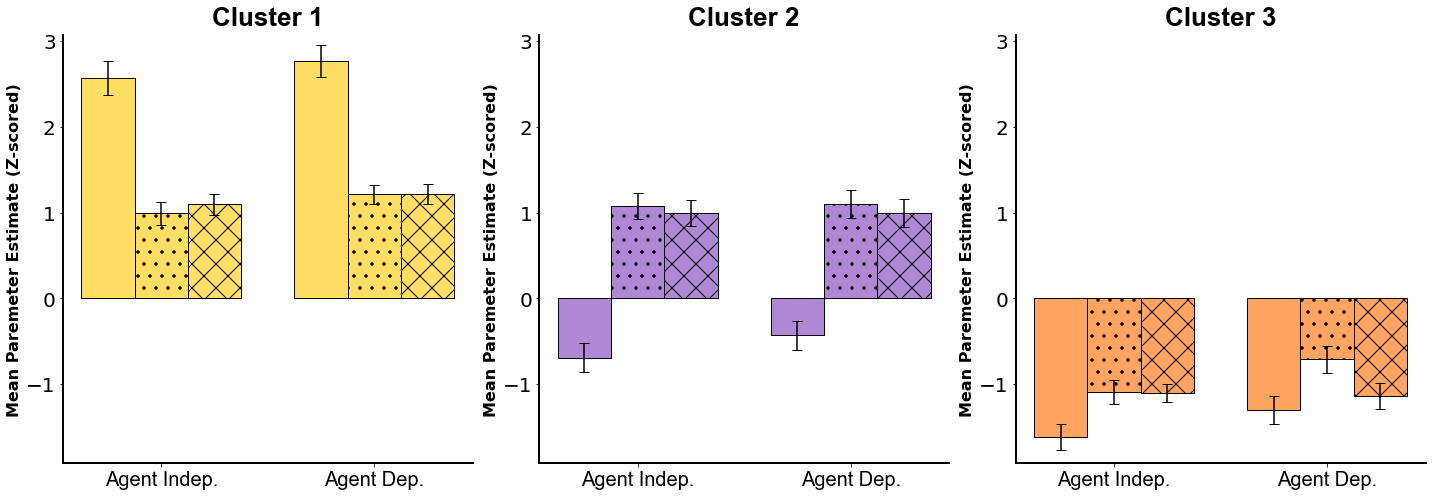

In [42]:


def create_grouped_barplot(data, groups):
    # Set up the figure and axes
    n_cols = 3
    fig, axes = plt.subplots(1, n_cols, figsize=(20,7))
    axes = axes.ravel()
    
    # Define style parameters
    width = 0.25  # Width of bars
    group_colors = ['#FFC800', '#7A3EB1', '#F76800']  # Colors for different groups
    conditions = ['obs', 'Congruent', 'PE']

    # First find the global min and max values across all groups
    all_values = []
    all_sems = []
    for group in groups:
        for cond in conditions:
            for main_cond in data['condition'].unique():
                subset = data[(data['condition'] == main_cond) & (data['video'] == cond)]
                all_values.append(subset[group].mean())
                all_sems.append(subset[group].sem())
    
    # Calculate global y-axis limits
    max_value = max(all_values) + max(all_sems) + 0.1
    min_value = min(all_values) - max(all_sems) - 0.1
    
    for idx, group in enumerate(groups):
        ax = axes[idx]
        base_color = group_colors[idx]
        light_color = lighten_color(base_color, 0.6)  # Create lighter shade
        
        # Get unique conditions
        unique_conditions = data['condition'].unique()
        
        # Calculate positions for bars
        x = np.arange(len(unique_conditions))
        
        # Plot bars for each condition type
        for i, cond in enumerate(conditions):
            # Calculate means and SEMs
            means = []
            sems = []
            for main_cond in unique_conditions:
                subset = data[(data['condition'] == main_cond) & (data['video'] == cond)]
                means.append(subset[group].mean())
                sems.append(subset[group].sem())
            
            # Set bar properties based on condition
            if cond == 'obs':
                color = light_color
                hatch = ''
            elif cond == 'PE':
                color = light_color
                hatch = 'x'
            else:  # congruent
                color = light_color
                hatch = '.'
            
            # Plot bars with error bars
            ax.bar(x + (i-1)*width, means, width, 
                  label=cond,
                  color=color,
                  hatch=hatch,
                  yerr=sems,
                  capsize=5,
                  edgecolor='black',  # Add black outline
                  linewidth=1)
            
            axes[i].set_ylabel('Mean Paremeter Estimate (Z-scored)', fontsize=16, fontweight='bold')
            # # Only set y-axis label for the left-most subplots
            # if i % n_cols == 0:  # First column of subplots
            #     axes[i].set_ylabel('Mean Paremeter Estimate (Z-scored)', fontsize=16, fontweight='bold')
            # else:
            #     axes[i].set_ylabel('')  # Remove y-axis label
            

            # Increase axis line width
            ax.spines['left'].set_linewidth(2)
            ax.spines['bottom'].set_linewidth(2)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            # Set uniform y-axis limits
            ax.set_ylim([min_value, max_value])

        ax.set_title(f'{group}', fontsize=26, pad=10, fontweight='bold', font='Arial')
        ax.set_xticks(x)
        ax.set_xticklabels(unique_conditions, fontsize=40, font='Arial')
        ax.tick_params(axis='both', which='major', labelsize=20)

        

        # # Add grid for better readability
        # ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Adjust layout
    # add more vertical space between subplots
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.5)
    return fig


groups = ['Cluster 1', 'Cluster 2', 'Cluster 3']
fig = create_grouped_barplot(df_brain, groups)
plt.show()

# Table S1: brain region analysis

In [43]:
cue_cols = [col for col in df_grouped_transposed.columns if 'obs_' in col]
fb_cols = [col for col in df_grouped_transposed.columns if 'fb_' in col]
roi_sub_z_df_cue = df_grouped_transposed[cue_cols]
roi_sub_z_df_fb = df_grouped_transposed[fb_cols]

# average social pattern cue videos such that the df is 3x30
sub_id_list = [col.split('sub-')[1].split("_video")[0] for col in roi_sub_z_df_cue.columns]
sub_id_list = ['sub-' + str(sub_id) for sub_id in sub_id_list]
roi_sub_z_df_cue = roi_sub_z_df_cue.T.reset_index(drop=True)
roi_sub_z_df_cue['sub'] = sub_id_list
roi_sub_z_df_cue = roi_sub_z_df_cue.groupby('sub').mean().T

# average Congruent and PE fb videos such that the df is 3x30
sub_id_list = [col.split('sub-')[1].split("_video")[0] for col in roi_sub_z_df_fb.columns]
sub_id_list = ['sub-' + str(sub_id) for sub_id in sub_id_list]
roi_sub_z_df_fb = roi_sub_z_df_fb.T.reset_index(drop=True)
roi_sub_z_df_fb['sub'] = sub_id_list
roi_sub_z_df_fb = roi_sub_z_df_fb.groupby('sub').mean().T

t_tests = []
for brain_region in df_grouped_transposed.index:
    cue_values = roi_sub_z_df_cue.loc[brain_region].values
    fb_values = roi_sub_z_df_fb.loc[brain_region].values
    
    # Perform the t-test
    t_test_result = pg.ttest(cue_values, fb_values, paired=True)
    t_test_result['brain_region'] = brain_region + 1
    t_tests.append(t_test_result)

ttests_df = pd.concat(t_tests)

ttests_df['p_bon'] = pg.multicomp(ttests_df['p-val'], method='bonferroni')[1]
ttests_df['p_fdr'] = pg.multicomp(ttests_df['p-val'], method='fdr_by')[1]    

In [ ]:
# select cue video columns
cue_pattern_cols = [col for col in df_grouped_transposed.columns if 'obs_Pattern' in col]
cue_social_cols = [col for col in df_grouped_transposed.columns if 'obs_Social' in col]
cue_pattern_df = df_grouped_transposed[cue_pattern_cols]
cue_social_df = df_grouped_transposed[cue_social_cols]
# convert to numeric
cue_pattern_df = cue_pattern_df.apply(pd.to_numeric, errors='coerce')
cue_social_df = cue_social_df.apply(pd.to_numeric, errors='coerce')
cue_social_df


In [ ]:
# for each cluster, test whether there is a significant difference between the pattern and social conditions

condition_tests = []
for cluster in df_grouped_transposed.index:
    pattern_values = cue_pattern_df.loc[cluster].values
    social_values = cue_social_df.loc[cluster].values
    
    # Perform the t-test
    t_test_result = pg.ttest(pattern_values, social_values, paired=True)
    condition_tests.append(t_test_result)
condition_tests_df = pd.concat(condition_tests)
condition_tests_df['p_bon'] = pg.multicomp(condition_tests_df['p-val'], method='bonferroni')[1]
condition_tests_df['p_fdr'] = pg.multicomp(condition_tests_df['p-val'], method='fdr_by')[1]
condition_tests_df['brain_region'] = df_grouped_transposed.index +1
condition_tests_df

In [ ]:
fb_cols = [col for col in df_grouped_transposed.columns if 'fb_' in col]

roi_fb_df = df_grouped_transposed[fb_cols]
# to numeric
roi_fb_df = roi_fb_df.apply(pd.to_numeric, errors='coerce')
roi_fb_df


In [ ]:

sub_id_list = [col.split('sub-')[1].split("_video")[0] for col in roi_fb_df.columns]
sub_id_list = ['sub-' + str(sub_id) for sub_id in sub_id_list]
roi_fb_df.columns = [col.split('video-')[1] for col in roi_fb_df.columns]
roi_df_groupd = roi_fb_df.T.reset_index()
roi_df_groupd.columns = ['trial'] + [f"brain_region_{i}" for i in range(1, len(roi_fb_df)+1)]
roi_df_groupd['condition'] = roi_df_groupd['trial'].str.split('_', expand=True)[1]
# rename condition to Social = agent-dependent, Pattern = agent-independent
roi_df_groupd.loc[roi_df_groupd['condition']=='Social', 'condition'] = 'agent-dependent'
roi_df_groupd.loc[roi_df_groupd['condition']=='Pattern', 'condition'] = 'agent-independent'
roi_df_groupd['feedback_type'] = roi_df_groupd['trial'].str.split('_', expand=True)[0]
roi_df_groupd['PE'] = roi_df_groupd['trial'].str.split('_', expand=True)[2]
roi_df_groupd.loc[roi_df_groupd['feedback_type']=='obs', 'PE'] = 'obs'
# drop video column and name PE column as video
roi_df_groupd = roi_df_groupd.drop(columns=['feedback_type'])
roi_df_groupd = roi_df_groupd.rename(columns={'PE':'feedback_type'})
roi_df_groupd['subject']=sub_id_list
roi_df_groupd

In [49]:
import pingouin as pg
anova_list = []
for i in range(1, len(roi_fb_df)+1):
    aov = pg.rm_anova(dv=f'brain_region_{i}', within=['condition', 'feedback_type'],
                    subject='subject', data=roi_df_groupd, effsize='n2')
    aov['brain_region'] = i
   
    anova_list.append(aov)
anova_df = pd.concat(anova_list)
anova_df['p_bon'] = pg.multicomp(anova_df['p-unc'], method='bonferroni')[1]
anova_df['p_fdr'] = pg.multicomp(anova_df['p-unc'], method='fdr_by')[1]

In [ ]:
anova_df[anova_df['p-unc'] < 0.05].sort_values('brain_region')

# Figure 5

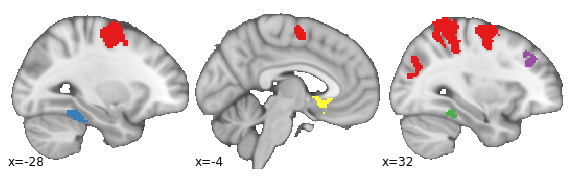

In [ ]:
# plot brain region 1, 13, 14, 15, 28

# shift the df_grouped up

new_to_old_roi = dict(enumerate(brain_regions, start=1))


brain_region_list = [1, 13, 14, 15, 28]
# use the mapping to get the reorganized brain region list
brain_region_list = [new_to_old_roi[region] for region in brain_region_list]
print(brain_region_list)
old_brain_regions = [roi_name_df.loc[roi_name_df['brain_region']==f'{r}', 'roi_name'] for r in brain_region_list]
print(old_brain_regions)

brain_region_list = [int(r.split('brain_region_')[1]) for r in brain_region_list]
print(brain_region_list)

roi_map = new_label_map


# # Create a mapping: old label → new label
label_mapping = {old: new for new, old in enumerate(brain_region_list, start=1)}


# Apply the mapping to the array
remapped_array = np.zeros_like(roi_map.get_fdata())
for old_label, new_label in label_mapping.items():
    remapped_array[roi_map.get_fdata() == old_label] = new_label


selected_roi_map = new_img_like(roi_map, remapped_array)
print(np.unique(selected_roi_map.get_fdata()))


bg_img = 'Data/MNI152_T1_1mm_brain.nii.gz'
# bg_img = 'Data/MNI152_T1_0.5mm_brain.nii.gz'
plotting.plot_roi(selected_roi_map, dim=-0.08, colorbar=False, draw_cross=False, cmap='Set1', display_mode='x', cut_coords=[-28, -4, 32], vmax=8, black_bg=False, bg_img = bg_img, alpha = 1)

In [167]:
nib.save(selected_roi_map, f'{second_level_res_dir}selected_roi_map.nii.gz')